<a href="https://colab.research.google.com/github/geovalexis/TFG/blob/main/notebooks/phylogenetic_profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Phylogenetic Profiling (PP)


## Profiling matrix creation


In [ ]:
# Count orthologs per human protein throughout the reference species

import pandas as pd
import numpy as np

human_orthologs = pd.read_csv("drive/MyDrive/TFG/human_orthologs2taxIDs.tsv", sep="\t", header=0, dtype={"human_gene": "string", "ortholog":"string", "ortholog_taxID":pd.Int64Dtype()})
sub2sp = pd.read_csv("drive/MyDrive/TFG/QFO_2018/subspecieID2specieID.tsv", sep="\t", header=0, dtype={"QfO_taxID":pd.Int64Dtype(), "specie_taxID": pd.Int64Dtype(), "species_name": "string"})

# Clean and check
#print("Species taxIDs:\n",sub2sp["QfO_taxID"].unique())
#print("\nOrthologs taxIDs:\n", human_orthologs["ortholog_taxID"].dropna().unique())
print("\nSpecies in the reference proteome for which any ortholog has been found:\n",np.setdiff1d(sub2sp["QfO_taxID"].unique(), human_orthologs["ortholog_taxID"].dropna().unique()))
print("\nOrthologs species that are not in the reference proteome:\n", np.setdiff1d(human_orthologs["ortholog_taxID"].dropna().unique(), sub2sp["QfO_taxID"].unique()))

# Count orthologs per human protein
taxa = np.intersect1d(sub2sp["QfO_taxID"].unique(), human_orthologs["ortholog_taxID"].dropna().unique())
proteins = human_orthologs["human_gene"].unique()
matrix = {}
for tax in taxa:
  tax_orthologs = human_orthologs[human_orthologs["ortholog_taxID"]==tax] # Orthologs between human and a specific specie
  matrix[tax] = []
  for protein in proteins:
    query = tax_orthologs["ortholog"].where(tax_orthologs["human_gene"]==protein).dropna() #To just count the nº of orthologs replace tolist() with count()
    if query.empty:
      matrix[tax].append([])
    else:
      matrix[tax].append(query.tolist())
orthologs_matrix_df = pd.DataFrame(matrix, index=proteins)
orthologs_counts_matrix = orthologs_matrix_df.applymap(lambda x: len(x))
orthologs_counts_matrix.to_csv("drive/MyDrive/TFG/orthologs_counts_matrix.tsv", sep="\t", index=True, header=True)
#orthologs_counts_matrix

# orthologs_counts_matrix[orthologs_counts_matrix[orthologs_counts_matrix[:]!=0].all(axis=1)] # Eliminar todas aquellas filas en las haya todo 0s

# PARA PRUEBAS:
# prova = ["Q8ND71", "Q7L211", "Q5JPI9"]
# tax_orthologs = human_orthologs[human_orthologs["ortholog_taxID"]==9598]
# print(tax_orthologs)
# for protein in prova:
#   print(tax_orthologs["ortholog"].where(tax_orthologs["human_protein"]==protein).dropna().tolist()) 



Species in the reference proteome for which any ortholog has been found:
 [7918 9606 83332 184922 224308 243273 559292 684364]

Orthologs species that are not in the reference proteome:
 []


## Profiling matrix reading

In [ ]:
getOrthologsPresenceMatrix()

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0
Q6IQ20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0
Q9H3J6,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0
Q14397,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0
Q8NFV4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,1,1,1,0,1,0,1,1,1,0,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A6NED7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
M0R036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
O14598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
Q5T7P6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Without GO terms

In [ ]:
import pandas as pd
import numpy as np

def getOrthologsPresenceMatrix():
    orthologs_counts_matrix = getOrthologsCountsMatrix()
    orthologs_counts_matrix_presence_absence = orthologs_counts_matrix.applymap(lambda x: 1 if x >= 1 else 0)
    return orthologs_counts_matrix_presence_absence

def getOrthologsCountsMatrix():
    orthologs_counts_matrix = pd.read_csv("drive/MyDrive/TFG/orthologs_counts_matrix.tsv", sep="\t", header=0, index_col=0)
    return orthologs_counts_matrix


### With GO terms

In [1]:
import pandas as pd
import numpy as np

def getOrthologsPresenceMatrix():
    orthologs_counts_matrix = getOrthologsCountsMatrix()
    orthologs_counts_matrix_presence_absence = orthologs_counts_matrix.applymap(lambda x: 1 if x >= 1 else 0)
    return orthologs_counts_matrix_presence_absence

def getOrthologsCountsMatrix():
    orthologs_counts_matrix = pd.read_csv("drive/MyDrive/TFG/MtP_201601_blasted-pp_matrix_counts.tab", sep="\t", header=0, index_col=0)
    orthologs_counts_matrix.drop(labels="GO_IDs", axis=1, inplace=True)
    return orthologs_counts_matrix

## Some visualization

In [ ]:
# Maximum value found in the dataset:
getOrthologsCountsMatrix().max().max()

188

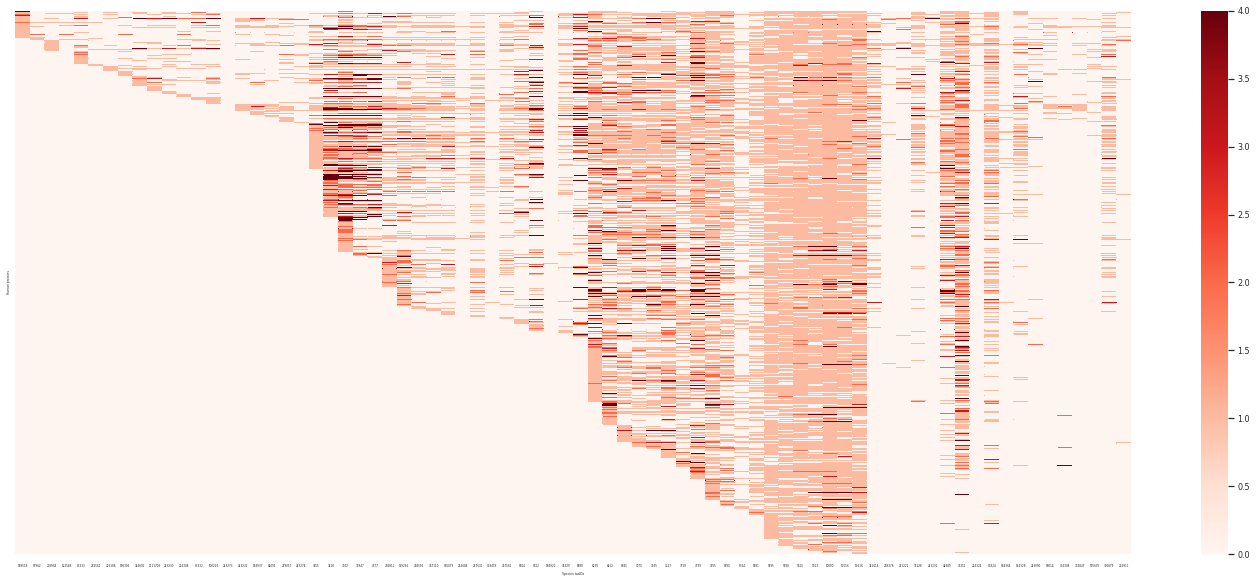

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

def plotHeatMap(matrix, ylabel_name="", xlabel_name="", save_name=None, vmin=None, vmax=None, **kwargs):
    sb.set(font_scale=0.25) # So that all the x labels can fit within the graph
    plt.figure(figsize=(25, 10))
    heat_map = sb.heatmap(matrix, cmap="Reds",  yticklabels=False, vmin=vmin, vmax=vmax, **kwargs) # The max nº of orthologs that has been found is 196, so we need to cut this off in order to have a good visualization
    # plt.tight_layout() # For avoiding matplot from saving the image with x label cut off
    # Change fontsize of the color bar 
    colorbar = heat_map.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=8)
    plt.ylabel(ylabel_name)
    plt.xlabel(xlabel_name)
    if save_name:
        plt.savefig(save_name, dpi=300)
    plt.show()
    plt.close()

plotHeatMap(getOrthologsCountsMatrix(), 
            ylabel_name='Human proteins', 
            xlabel_name="Species taxIDs", 
            #save_name='drive/MyDrive/TFG/orthologs_counts_heatmap.png', 
            vmax=4
            )


## Distance Matrix


Any of the differente distance metrics (cosine, hammington, hamming..) will be used for directly assign pair-wise comparison of the vectors.

References:
* Calculate distance matrixes : https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist 
* Different type of distance metrics: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html 

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform 

# Compute a distance matrix with SciPy (it automatically "normalized" the data -> distances are calculated having into account the size of the dataset)
def computeDistanceMatrix(matrix, distance_metric):
    Y = pdist(matrix, metric=distance_metric) # uncondensed distance matrix
    return Y

 

In [ ]:
# Implementation of the matrix with Sklearn (normalized also):
from sklearn.metrics import pairwise_distances

def computeDistanceMatrix(matrix, distance_metric):
  Y = pairwise_distances(matrix, metric=distance_metric) # Directly gives a condensed matrix 
  Y = squareform(Y) # To condense the matrix (yes, it does both) in case it is needed in this form (Scipy needs the matrix as condense to compute the dendogram)
                    # squareform is used for both condense or uncodense a given matrix
  return Y   

### With Hamming distance

In [ ]:
# NOT USED
# Manual implementation of the matrix:
def HammingDistance(v1: np.array, v2: np.array):
  return np.count_nonzero(np.bitwise_xor(v1, v2) == 1)

v1 = np.array([1,0])
v2 = np.array([1,1])
HammingDistance(v1,v2)

1

In [ ]:
X = getOrthologsPresenceMatrix()
Y = computeDistanceMatrix(X, "hamming")
pd.DataFrame(squareform(Y)) 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5214,5215,5216,5217,5218,5219,5220,5221,5222,5223,5224,5225,5226,5227,5228,5229,5230,5231,5232,5233,5234,5235,5236,5237,5238,5239,5240,5241,5242,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252,5253
0,0.000000,0.342857,0.242857,0.328571,0.128571,0.385714,0.314286,0.128571,0.214286,0.228571,0.342857,0.214286,0.242857,0.142857,0.228571,0.185714,0.300000,0.428571,0.314286,0.271429,0.171429,0.357143,0.257143,0.471429,0.200000,0.085714,0.114286,0.357143,0.114286,0.228571,0.271429,0.428571,0.314286,0.300000,0.342857,0.542857,0.385714,0.385714,0.271429,0.314286,...,0.100000,0.085714,0.085714,0.100000,0.100000,0.085714,0.085714,0.085714,0.085714,0.100000,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.071429,0.071429,0.085714,0.085714,0.085714,0.085714,0.071429,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.100000,0.085714,0.085714,0.085714,0.085714
1,0.342857,0.000000,0.328571,0.471429,0.271429,0.242857,0.314286,0.385714,0.357143,0.371429,0.428571,0.300000,0.214286,0.314286,0.342857,0.300000,0.328571,0.285714,0.342857,0.328571,0.314286,0.242857,0.314286,0.242857,0.257143,0.314286,0.228571,0.528571,0.342857,0.342857,0.214286,0.285714,0.285714,0.385714,0.400000,0.342857,0.328571,0.300000,0.357143,0.228571,...,0.357143,0.342857,0.342857,0.357143,0.328571,0.342857,0.342857,0.342857,0.342857,0.328571,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.328571,0.328571,0.342857,0.342857,0.342857,0.342857,0.328571,0.342857,0.342857,0.342857,0.314286,0.314286,0.314286,0.314286,0.314286,0.300000,0.314286,0.314286,0.314286,0.314286
2,0.242857,0.328571,0.000000,0.314286,0.257143,0.342857,0.242857,0.142857,0.228571,0.214286,0.357143,0.285714,0.228571,0.214286,0.185714,0.200000,0.228571,0.385714,0.271429,0.285714,0.214286,0.342857,0.242857,0.400000,0.214286,0.185714,0.242857,0.485714,0.185714,0.271429,0.200000,0.357143,0.271429,0.342857,0.328571,0.471429,0.428571,0.314286,0.342857,0.300000,...,0.228571,0.242857,0.242857,0.228571,0.228571,0.214286,0.214286,0.214286,0.214286,0.200000,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.228571,0.228571,0.214286,0.214286,0.214286,0.214286,0.228571,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.200000,0.214286,0.214286,0.214286,0.214286
3,0.328571,0.471429,0.314286,0.000000,0.342857,0.485714,0.328571,0.285714,0.342857,0.328571,0.357143,0.400000,0.371429,0.271429,0.271429,0.285714,0.371429,0.385714,0.300000,0.285714,0.328571,0.485714,0.328571,0.571429,0.385714,0.328571,0.300000,0.485714,0.300000,0.357143,0.342857,0.442857,0.414286,0.342857,0.328571,0.442857,0.457143,0.428571,0.400000,0.414286,...,0.342857,0.328571,0.328571,0.342857,0.314286,0.328571,0.328571,0.328571,0.328571,0.314286,0.328571,0.328571,0.328571,0.328571,0.328571,0.328571,0.328571,0.328571,0.328571,0.328571,0.314286,0.314286,0.328571,0.328571,0.328571,0.328571,0.314286,0.328571,0.328571,0.328571,0.300000,0.300000,0.300000,0.300000,0.300000,0.314286,0.300000,0.300000,0.328571,0.328571
4,0.128571,0.271429,0.257143,0.342857,0.000000,0.371429,0.357143,0.200000,0.228571,0.214286,0.357143,0.228571,0.314286,0.157143,0.242857,0.171429,0.342857,0.414286,0.271429,0.257143,0.214286,0.342857,0.271429,0.428571,0.214286,0.071429,0.128571,0.400000,0.128571,0.271429,0.285714,0.385714,0.357143,0.314286,0.357143,0.471429,0.342857,0.314286,0.285714,0.300000,...,0.114286,0.100000,0.100000,0.114286,0.114286,0.100000,0.100000,0.100000,0.100000,0.114286,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.085714,0.085714,0.100000,0.100000,0.100000,0.100000,0.085714,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.114286,0.100000,0.100000,0.100000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...

### With Jaccart distance

In [ ]:
X = getOrthologsPresenceMatrix()
Y = computeDistanceMatrix(X, "jaccard") # uncondensed distance matrix
pd.DataFrame(squareform(Y)) # condense distance matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5214,5215,5216,5217,5218,5219,5220,5221,5222,5223,5224,5225,5226,5227,5228,5229,5230,5231,5232,5233,5234,5235,5236,5237,5238,5239,5240,5241,5242,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252,5253
0,0.000000,0.923077,0.894737,0.920000,0.900000,0.900000,0.880000,0.750000,0.882353,0.888889,0.923077,0.882353,0.809524,0.833333,0.888889,0.928571,0.913043,0.937500,0.916667,0.863636,0.800000,0.862069,0.818182,0.916667,0.777778,0.857143,0.727273,0.892857,0.888889,0.888889,0.863636,0.937500,0.846154,0.875000,0.923077,0.950000,0.931034,0.931034,0.950000,0.916667,...,1.000000,1.0,1.0,1.000000,1.000000,1.0000,1.0000,1.0000,1.0000,1.000000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0000,1.0000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.923077,0.000000,0.741935,0.846154,0.791667,0.500000,0.647059,0.900000,0.806452,0.812500,0.789474,0.724138,0.517241,0.814815,0.774194,0.777778,0.696970,0.555556,0.705882,0.696970,0.758621,0.500000,0.666667,0.459459,0.620690,0.916667,0.666667,0.860465,0.923077,0.774194,0.517241,0.555556,0.588235,0.750000,0.756757,0.571429,0.638889,0.600000,0.781250,0.533333,...,1.000000,1.0,1.0,1.000000,0.958333,1.0000,1.0000,1.0000,1.0000,0.958333,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0000,1.0000,1.0000,0.956522,0.956522,0.956522,0.956522,0.956522,0.913043,0.956522,0.956522,0.956522,0.956522
2,0.894737,0.741935,0.000000,0.733333,0.900000,0.705882,0.607143,0.555556,0.695652,0.652174,0.781250,0.800000,0.615385,0.750000,0.590909,0.700000,0.615385,0.750000,0.678571,0.714286,0.681818,0.705882,0.629630,0.717949,0.625000,0.812500,0.809524,0.894737,0.764706,0.760000,0.560000,0.714286,0.633333,0.774194,0.741935,0.767442,0.833333,0.687500,0.857143,0.724138,...,0.941176,1.0,1.0,0.941176,0.941176,0.9375,0.9375,0.9375,0.9375,0.875000,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,1.0,1.0,0.9375,0.9375,0.9375,0.9375,1.0,0.9375,0.9375,0.9375,0.937500,0.937500,0.937500,0.937500,0.937500,0.875000,0.937500,0.937500,0.937500,0.937500
3,0.920000,0.846154,0.733333,0.000000,0.923077,0.809524,0.676471,0.769231,0.800000,0.766667,0.714286,0.875000,0.764706,0.760000,0.678571,0.769231,0.764706,0.692308,0.656250,0.645161,0.793103,0.809524,0.696970,0.833333,0.818182,0.958333,0.807692,0.829268,0.875000,0.806452,0.727273,0.756098,0.763158,0.705882,0.676471,0.688889,0.800000,0.769231,0.848485,0.805556,...,1.000000,1.0,1.0,1.000000,0.956522,1.0000,1.0000,1.0000,1.0000,0.956522,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0000,1.0000,1.0000,0.954545,0.954545,0.954545,0.954545,0.954545,0.956522,0.954545,0.954545,1.000000,1.000000
4,0.900000,0.791667,0.900000,0.923077,0.000000,0.866667,0.925926,0.933333,0.888889,0.833333,0.925926,0.888889,0.916667,0.846154,0.894737,0.857143,0.960000,0.906250,0.826087,0.818182,0.882353,0.827586,0.826087,0.857143,0.789474,0.714286,0.750000,0.933333,0.900000,0.950000,0.869565,0.870968,0.892857,0.880000,0.925926,0.868421,0.857143,0.814815,0.952381,0.875000,...,1.000000,1.0,1.0,1.000000,1.000000,1.0000,1.0000,1.0000,1.0000,1.000000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0000,1.0000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5249,1.000000,0.913043,0.875000,0.956522,1.000000,0.965517,0.9

## Clustering 

Remember that clustering is part of Unsupervised Machine Learning

### Hierarchical clustering

References:
* Different linkage methods: https://es.mathworks.com/help/stats/linkage.html?lang=en 
Summary: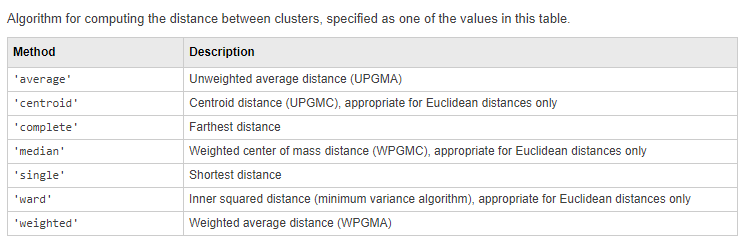

* Cluster analysis (Inconsistency explanation on Page 11): http://cda.psych.uiuc.edu/multivariate_fall_2013/matlab_help/cluster_analysis.pdf 

* Inconsistency cut-off with scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster 

In [ ]:
import matplotlib.pyplot as plt

def plotDendogram(Z):    
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(Z) #NOTE: this process consumes a lot of resources
    plt.show()
    plt.close()


#### Using the precomputed distance matrix

##### With sklearn

In [3]:
# Based on https://towardsdatascience.com/hierarchical-clustering-explained-e58d2f936323 example

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform 
import pandas as pd

def getLinkageMatrixSklearn(Y, distance_threshold=0.1, linkage_method="complete", affinity="precomputed"):
    model = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold, linkage=linkage_method, affinity=affinity) 
    model = model.fit(squareform(Y))
    return linkage(model.children_, method=linkage_method, metric=None)

def getClusterLabelsSklearn(Y, distance_threshold=0.1, linkage_method="complete", affinity="precomputed", plot_dendogram=False):
    # See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html 
    # Cutting-off by distance_threshold in sklearn's AgglomerativeClustering should the same as doing an fcluster(Z, t=threshold, criterion='distance') 
    model = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold, linkage=linkage_method, affinity=affinity) 
    model = model.fit(squareform(Y))
    print("Total number of clusters:", model.n_clusters_)
    print("Minimum distance between clusters:", model.distances_.min())
    print("Maximum distance between clusters:", model.distances_.max())
    if plot_dendogram:
        Z = linkage(model.children_, method=linkage_method) # Important to use the same linkage method as above (so that the dendogram corresponds)
        #Z = linkage(Y, method=linkage_method)  # NOTE: Why using Y matrix gives differentes results? if it's a 1-D condensed matrix...
        plotDendogram(Z) # also plotDendogram(mode.distances_) ?? It supposed to give directly an array to plot a dendogram and this way save some computation cost. See at documentation.

    return model.labels_ # CLUSTERS labels. It gives the same array as if we had run fit_predict() method


Total number of clusters: 1574
Minimum distance between clusters: 0.0
Maximum distance between clusters: 0.7428571428571429


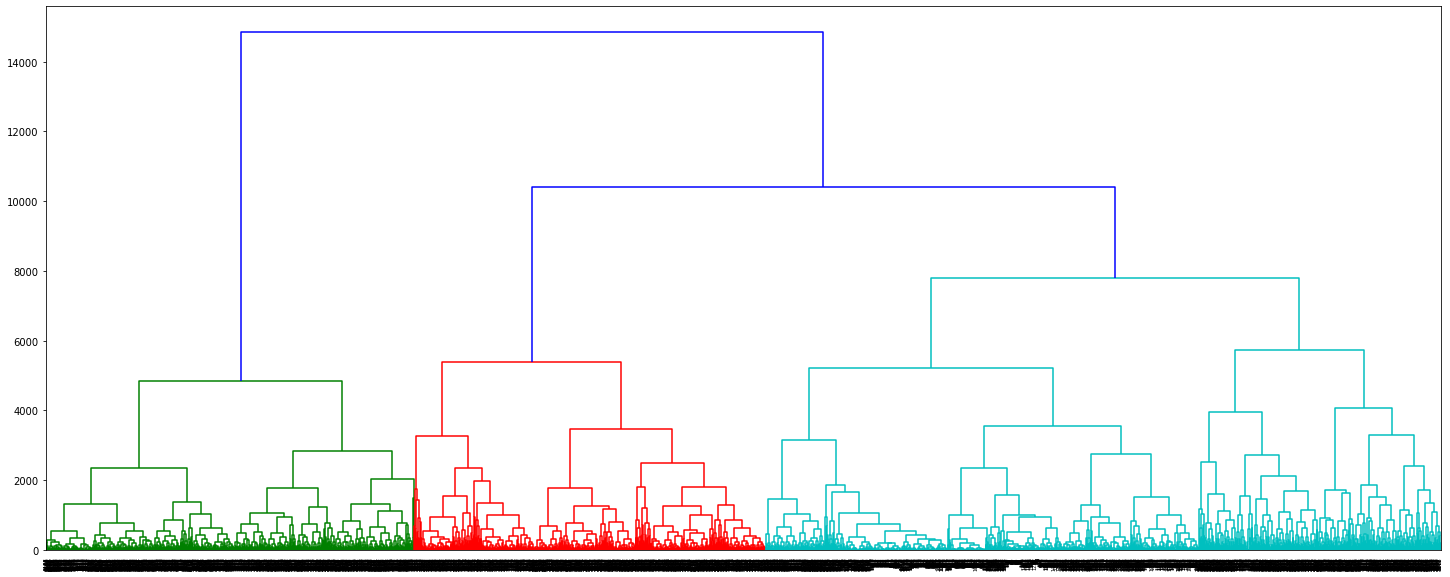

array([ 75, 941, 940, ..., 524, 154, 154])

In [ ]:
X = getOrthologsPresenceMatrix()
Y = computeDistanceMatrix(X, "hamming")
getClusterLabelsSklearn(Y, distance_threshold=0.1, plot_dendogram=True)

##### With scipy

In [4]:
# Snippet of code inspired from this paper https://www.embopress.org/doi/full/10.1038/msb.2013.50#msb201350-fig-0001 (within the "Generation of coevolved gene clusters" section)

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

def getLinkageMatrixScipy(Y, linkage_method="ward", distance_metric="euclidean"):
    return linkage(Y, method=linkage_method, metric=distance_metric)

def getClusterLabelsScipy(Y, linkage_method="ward", distance_metric="euclidean", criterion="inconsistent", criterion_threshold=1, plot_dendogram=False):
    Z = linkage(Y, method=linkage_method, metric=distance_metric) # When a condensed matrix is passed (Y), then the metric parameter is ignored ??
    # Number of different clusters
    clusters_labels = fcluster(Z, t=criterion_threshold, criterion=criterion)
    print("Total number of clusters:", len(set(clusters_labels)))
    #print("Minimum distance between clusters:", #TODO)
    #print("Maximum distance between clusters:", #TODO)
    if plot_dendogram:
        plotDendogram(Z)
    return clusters_labels
    

Total number of clusters: 1529


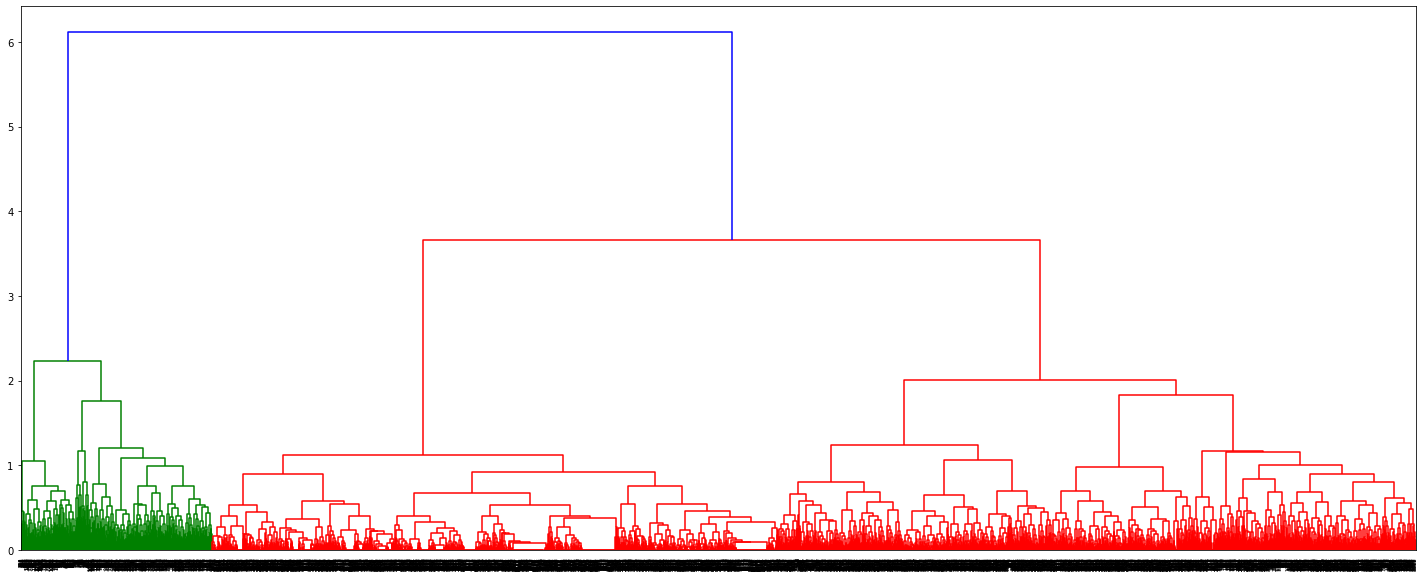

array([464,  58, 693, ..., 646, 654, 654], dtype=int32)

In [ ]:
X = getOrthologsPresenceMatrix()
Y = computeDistanceMatrix(X, "hamming")
getClusterLabelsScipy(Y, criterion_threshold=1, plot_dendogram=True)

# The following is supposed to give the same plot as the previous one (with sklearn) -> IT DOES NOT, WHY?
# getClusterLabelsScipy(Y, linkage_method="complete", distance_metric=None, plot_dendogram=True)

#### Directly using the phylogenetic profile matrix

**SECTION DEPRECATED** : I think this is not a correct way of performing this kind analysis. 

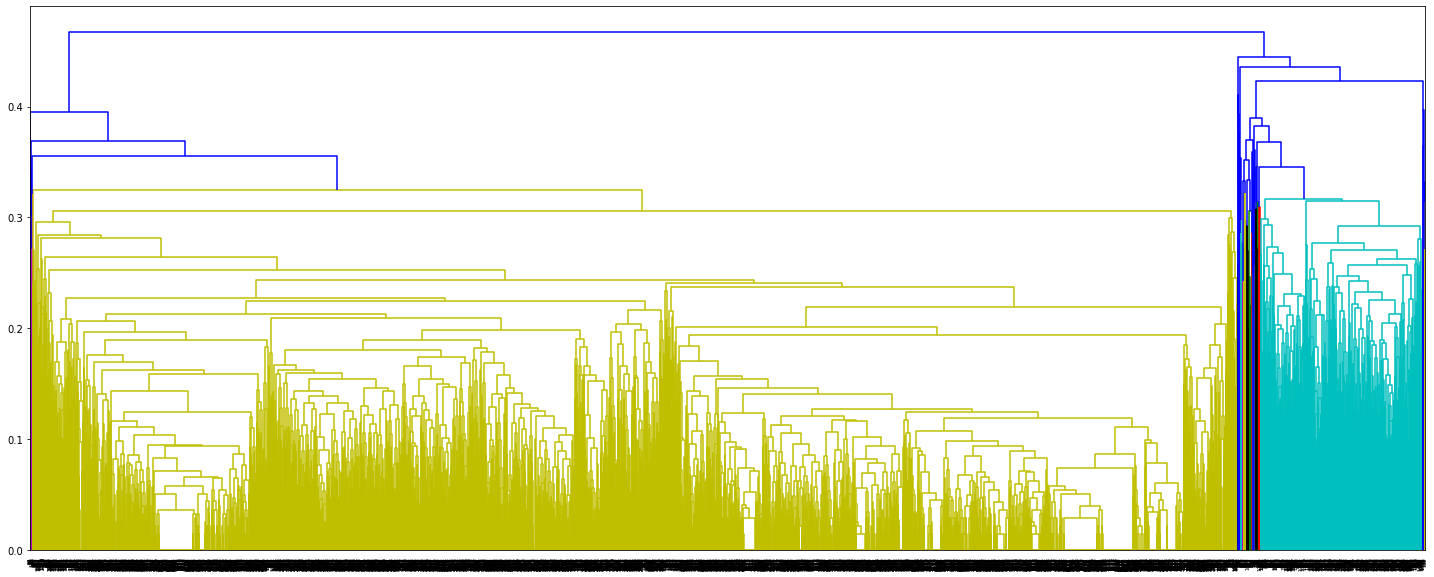

1486


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

Z = linkage(orthologs_counts_matrix_presence_absence, method='weighted', metric="hamming")
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

# Number of different clusters
print(len(set(fcluster(Z, t=1, criterion='inconsistent'))))

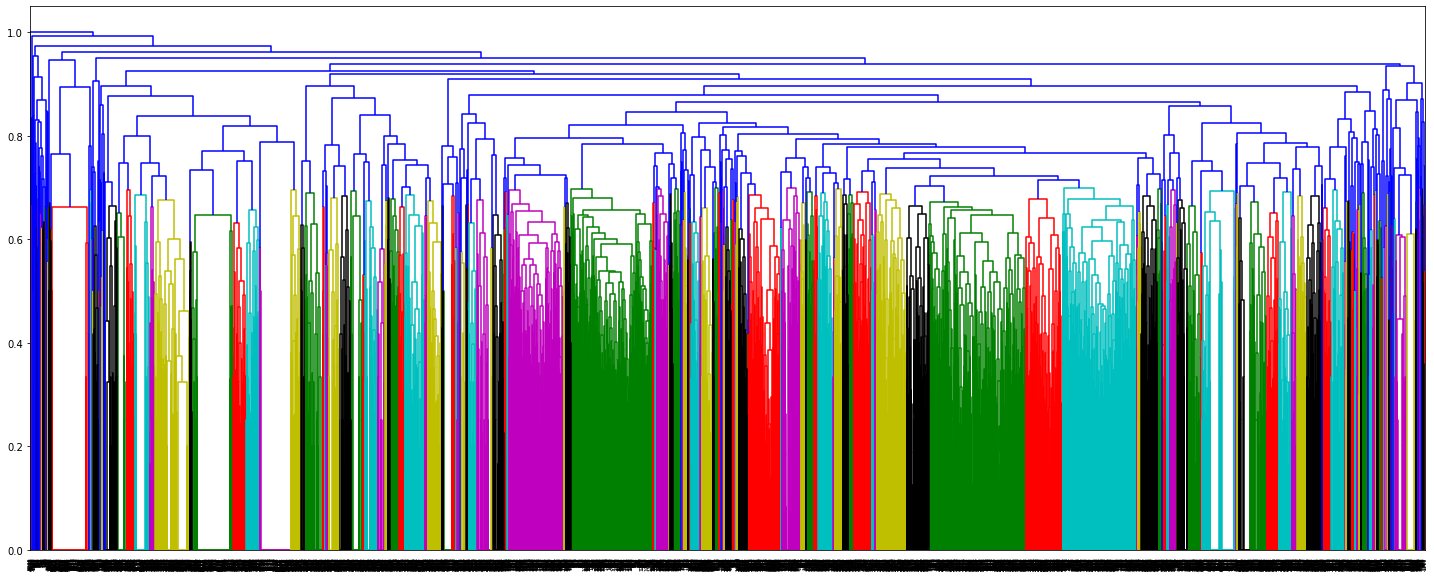

1439


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(orthologs_counts_matrix_presence_absence, method='weighted', metric="jaccard")
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

# Number of different clusters
print(len(set(fcluster(Z, t=1, criterion='inconsistent'))))

### K-means

**SECTION DEPRECATED**: I think this not useful

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

orthologs_counts_matrix = pd.read_csv("drive/MyDrive/TFG/orthologs_counts_matrix.tsv", sep="\t", header=0, index_col=0)
orthologs_counts_matrix_presence_absence = orthologs_counts_matrix.applymap(lambda x: 1 if x >= 1 else 0)
orthologs_counts_matrix_presence_absence.head()

X_std = orthologs_counts_matrix_presence_absence #StandardScaler().fit_transform(orthologs_counts_matrix_presence_absence)
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(X_std)
clusters

array([6, 3, 9, ..., 5, 5, 5], dtype=int32)

#### Visualizing with PCA

Text(0, 0.5, 'PCA 2')

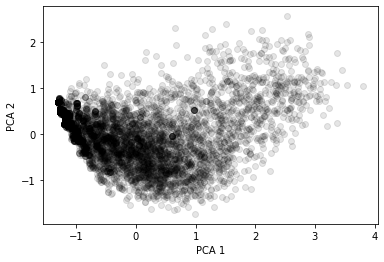

In [ ]:
# Credits: https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

# Standardize the data to have a mean of ~0 and a variance of 1
X_std = orthologs_counts_matrix_presence_absence #StandardScaler().fit_transform(orthologs_counts_matrix_presence_absence)

# Create a PCA instance: pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
PCA_components = pd.DataFrame(principalComponents)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


## Clusters analysis

In [ ]:
# Prerequisites
orthologs_counts_matrix_presence_absence = getOrthologsPresenceMatrix()
Y = computeDistanceMatrix(orthologs_counts_matrix_presence_absence, "hamming")
cluster_labels = getClusterLabelsSklearn(Y)
orthologs_counts_matrix_presence_absence["cluster"] = cluster_labels


Total number of clusters: 1574
Minimum distance between clusters: 0.0
Maximum distance between clusters: 0.7428571428571429


### Some validation

In [ ]:

# The cluster with less genes has:
print("Min genes per cluster: ", orthologs_counts_matrix_presence_absence.groupby("cluster").size().min())

# The cluster with more gene has:
print("Max genes per cluster:", orthologs_counts_matrix_presence_absence.groupby("cluster").size().max())

# The average genes that the clusters have:
print("Average genes per cluster:", orthologs_counts_matrix_presence_absence.groupby("cluster").size().mean())

# Agroping genes by cluster
orthologs_counts_matrix_presence_absence.index.set_names("gene", inplace=True)
orthologs_counts_matrix_presence_absence.reset_index(inplace=True)
orthologs_counts_matrix_presence_absence.set_index(["cluster", "gene"], inplace=True)
orthologs_counts_matrix_presence_absence.sort_index()


Min genes per cluster:  1
Max genes per cluster: 172
Average genes per cluster: 3.337992376111817


3055  3218  3702  4577  ...  436308  515635  665079  1111708
cluster gene                            ...                                 
0       Q9BZ23     0     0     0     0  ...       0       0       0        0
        Q9H2T7     0     1     0     0  ...       0       0       0        0
        Q9UIA9     0     1     0     0  ...       0       0       0        0
1       E7EQ34     0     1     0     0  ...       0       0       1        0
        O14653     0     0     0     0  ...       0       0       1        0
...              ...   ...   ...   ...  ...     ...     ...     ...      ...
1569    Q86TV6     0     0     0     0  ...       0       0       0        0
1570    Q86VX9     1     0     0     0  ...       0       0       1        0
1571    P35251     1     0     0     1  ...       0       0       1        0
1572    Q9HD42     1     1     0     1  ...       0       0       1        0
1573    Q8IYB7     0     0     0     0  ...       0       0       0        1

[5254 rows x 70 columns]

In [ ]:
# Look for a cluster to have certain amount of genes (15 in this case)
orthologs_counts_matrix_presence_absence.unstack()[orthologs_counts_matrix_presence_absence.groupby(level=["cluster"]).size() > 15].index.values


array([  21,   22,   35,   38,   47,   49,   50,   52,   58,   73,   75,
         85,   86,   87,   93,  116,  130,  148,  152,  177,  181,  195,
        269,  298,  300,  306,  348,  366,  402,  524,  549,  605,  612,
        613,  708,  712,  915, 1396])

In [ ]:
# Pick one of the above clusters and see what genes it has
cluster = 21
orthologs_counts_matrix_presence_absence.loc[cluster]
#orthologs_counts_matrix_presence_absence.loc[cluster].to_csv(f"drive/MyDrive/TFG/cluster_{cluster}.tsv", sep="\t")

,3055,3218,3702,4577,5664,5722,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,35128,36329,39947,44689,45351,64091,69014,81824,83333,85962,100226,122586,164328,188937,189518,190304,208964,214684,224324,224911,226186,237561,237631,243090,243230,243231,243232,243274,251221,272561,273057,284591,284812,289376,321614,324602,330879,367110,374847,418459,436308,515635,665079,1111708
gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Q68CJ6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
Q9H343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q9ULI3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q14533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q8N6V4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q9P0K1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
H0Y3Z8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A8MTA8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A6NK06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Order heatmap by clusters size 
sorted_clusters = orthologs_counts_matrix_presence_absence.groupby(level=["cluster"]).size().sort_values(ascending=True)
ort_counts_pr_abs_sorted_by_cluster_size = orthologs_counts_matrix_presence_absence.reindex(level="cluster", index=sorted_clusters.index.values)
#plotHeatMap(ort_counts_pr_abs_sorted_by_cluster_size)

## Hierchical clustered heatmap 


In [5]:
# For translating the taxIDs to their corresponding complete names

!pip install ete3
from ete3 import NCBITaxa

def getSpeciesNames(taxa: list):
    ncbi = NCBITaxa()
    tax2names = ncbi.get_taxid_translator(taxa)
    #speciesNames = [tax2names[i] for i in taxa]
    return tax2names



In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

original_matrix = getOrthologsPresenceMatrix()
original_matrix.columns = original_matrix.columns.astype("int32")
original_matrix.rename(columns=getSpeciesNames(list(original_matrix.columns)), inplace=True)

Y_genes = computeDistanceMatrix(original_matrix, "hamming")
Z_genes = getLinkageMatrixScipy(Y_genes)
Y_species = computeDistanceMatrix(original_matrix.T, #Transposed so it computes the distance matrix for the columns (species)
                                  distance_metric="hamming") 
Z_species = getLinkageMatrixScipy(Y_species)

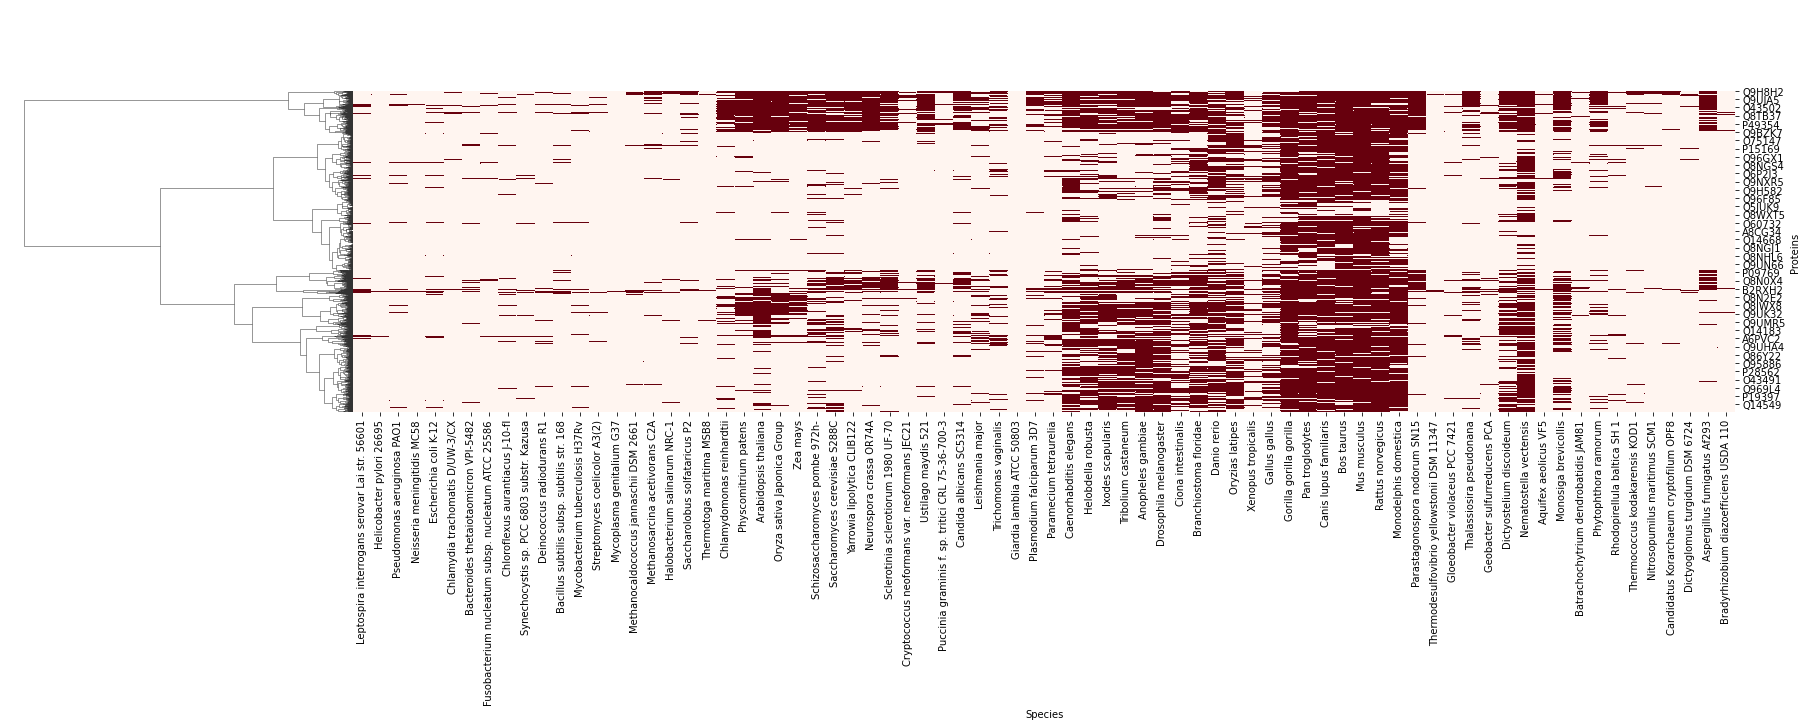

In [15]:
plot = sns.clustermap(original_matrix, 
               #method='complete', metric='hamming', 
               standard_scale=None, figsize=(25, 10), 
               row_cluster=True, col_cluster=False, 
               row_linkage=Z_genes, col_linkage=Z_species, 
               cbar=False,
               cmap="Reds",        # Other way sns.mpl_palette("reds",n_colors=2, as_cmap=True))
               )
plot.ax_heatmap.set_ylabel("Proteins")
plot.ax_heatmap.set_xlabel("Species")
plot.cax.set_visible(False)
plot

In [13]:
plot.savefig("drive/MyDrive/TFG/MtP_201601_blasted-Clustered_Heat_Map.jpeg", format="jpeg", dpi=600)

## GO enrichment